In [13]:
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

import xgboost as xgb
import pickle
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
import cv2
import sys
from skimage.metrics import structural_similarity, normalized_root_mse, adapted_rand_error, hausdorff_distance, peak_signal_noise_ratio
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from meme_classifier.images import process_image, templates, compare_images
import matplotlib.pyplot as plt
import psycopg2
import json
from shutil import copyfile
%matplotlib inline

In [2]:
csv_path = 'train_data.csv'
template_path = '../template'

In [3]:
columns = []
for t in templates:
    columns.extend((
        t[1] + '_similarity',
        t[1] + '_mse',
        t[1] + '_compare_hist'
        #t[1] + '_adapted_rand_error_are',
        #t[1] + '_adapted_rand_error_prec',
        #t[1] + '_adapted_rand_error_rec',
        #t[1] + '_hausdorff_distance',
        #t[1] + '_hpsnr',
    ))
columns.append('label')

In [4]:
with open(os.path.join('..', 'ChatExport', 'result.json'), 'r') as fp:
    exports = json.load(fp)

In [5]:
conn = psycopg2.connect(os.getenv('POSTGRES_CREDENTIALS'))

In [6]:
cur = conn.cursor()
cur.execute('SELECT chat_id, message_id FROM meme WHERE bad_template IS NOT NULL')
cur.fetchall()[:10]

[(-1001408931466, 13276),
 (-1001408931466, 9339),
 (-1001408931466, 16400),
 (-1001408931466, 4761),
 (-1001408931466, 634),
 (-1001408931466, 14979),
 (-1001408931466, 15091),
 (-1001408931466, 12304),
 (-1001408931466, 11842),
 (-1001408931466, 1499)]

In [7]:
for m in exports['messages']:
    if 'photo' in m:
        p = os.path.join('..', 'ChatExport', m['photo'])
        copyfile(p, os.path.join('..', 'train', 'garbage', os.path.basename(p)))

In [15]:
def get_row(path, label):
    cols = []
    after = cv2.imread(path)
    for _, template_name, template_image in templates:
        comparison = compare_images(template_image, after)
        cols.extend((
            comparison['similarity'], 
            comparison['mse'],
            comparison['compare_hist']
            #comparison['adapted_rand_error_are'],
            #comparison['adapted_rand_error_prec'],
            #comparison['adapted_rand_error_rec'],
            #comparison['hausdorff_distance'],
            #comparison['psnr'],
        ))
    cols.append(label)
    return cols

rows = []
for root, dirs, files in os.walk(os.path.join('..', 'train')):
    if os.path.basename(root) == 'train':
        continue
    if os.path.basename(root) == 'garbage':
        label = 0
    else:
        label = [t[0] for t in templates if os.path.basename(root) == t[1]][0]

    for f in files:
        rows.append(get_row(os.path.join(root, f), label))

    df = pd.DataFrame(rows, columns=columns)
    df.to_csv(csv_path)

In [16]:
df = pd.read_csv(csv_path)

In [17]:
X = df.drop(['label', 'Unnamed: 0'] + [c for c in columns if
                                       c.endswith('rand_error_prec') or
                                        c.endswith('rand_error_rec') or
                                        c.endswith('rand_error_are') or
                                        c.endswith('hpsnr') or
                                        c.endswith('_hausdorff_distance') or
                                       False
                                      ], axis=1).fillna(0)
y = df['label'].astype(int)

for c in X.columns:
    mask = df[c] != np.inf
    df.loc[~mask, c] = df.loc[mask, c].max()
X

,rubhands.jpg_similarity,rubhands.jpg_mse,rubhands.jpg_compare_hist,expandingbrain4.jpg_similarity,expandingbrain4.jpg_mse,expandingbrain4.jpg_compare_hist,dogapocalypse.webp_similarity,dogapocalypse.webp_mse,dogapocalypse.webp_compare_hist,Two-Buttons.jpg_similarity,...,spidermanpresentation.jpg_compare_hist,leftexitmeme.jpg_similarity,leftexitmeme.jpg_mse,leftexitmeme.jpg_compare_hist,herewegoagain.jpg_similarity,herewegoagain.jpg_mse,herewegoagain.jpg_compare_hist,fracasado.jpg_similarity,fracasado.jpg_mse,fracasado.jpg_compare_hist
0,0.300937,0.501294,0.626176,0.178959,0.690593,0.752857,0.230511,0.636255,0.836551,0.190340,...,0.733770,0.208677,0.967824,0.825238,0.185511,1.161793,0.828989,0.138830,0.861719,0.789760
1,0.268079,0.479718,0.507723,0.152092,0.712790,0.747634,0.199245,0.669085,0.843100,0.189397,...,0.766139,0.182899,1.011530,0.814647,0.171406,1.187200,0.853842,0.129924,0.862486,0.765514
2,0.370474,0.433283,0.465923,0.160732,0.719834,0.749474,0.208676,0.649377,0.839308,0.196320,...,0.769972,0.177257,0.999564,0.834457,0.196248,1.142979,0.847296,0.132398,0.862043,0.786388
3,0.238855,0.501872,0.555025,0.175580,0.594166,0.891910,0.172633,0.592775,0.814662,0.140297,...,0.819398,0.158472,0.882160,0.755537,0.157236,0.923969,0.871053,0.106424,0.759422,0.706271
4,0.376774,0.478183,0.384065,0.192321,0.732320,0.738784,0.225081,0.678817,0.861671,0.203010,...,0.784354,0.191190,1.036382,0.840944,0.195667,1.186387,0.876792,0.151819,0.898931,0.808838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7551,0.182567,0.613749,0.777296,0.156485,0.609089,0.921122,0.172893,0.523811,0.738494,0.125065,...,0.863590,0.170148,0.690501,0.727496,0.148883,0.739498,0.918866,0.218792,0.417416,0.384629
7552,0.183030,0.630847,0.765243,0.159802,0.612159,0.869582,0.173216,0.550215,0.751798,0.133519,...,0.836169,0.175825,0.701960,0.715389,0.157003,0.763519,0.930106,0.214523,0.450104,0.416258
7553,0.211803,0.586074,0.765781,0.163141,0.611262,0.936228,0.179850,0.526871,0.744839,0.144702,...,0.882462,0.196221,0.677475,0.709975,0.168451,0.753440,0.923975,0.133854,0.573722,0.467601
7554,0.161112,0.631456,0.775803,0.139600,0.640205,0.905654,0.139974,0.583988,0.729575,0.114474,...,0.850650,0.147494,0.722557,0.730768,0.124645,0.789591,0.917410,0.621362,0.245512,0.303986


In [18]:
classifier = xgb.XGBClassifier(use_label_encoder=False)

In [19]:
print(cross_val_score(classifier, X, y.values, cv=3))

[02:33:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:34:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:34:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.930131   0.92417626 0.92295473]


In [20]:
classifier.fit(X, y)
pickle.dump(classifier, open(f'classifier-{csv_path}.pickle', "wb"))

[02:35:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [21]:
classifier = pickle.load(open(f'classifier-{csv_path}.pickle', "rb"))

In [22]:
sorted(classifier.get_booster().get_score(importance_type="gain").items(), key=lambda x: x[1])

[('heman.jpg_mse', 0.03579026422006667),
 ('bigdogsmalldog.png_mse', 0.0379521111740205),
 ('bikefall.jpg_similarity', 0.039787785713305164),
 ('phoebeteachingjoey.jpg_mse', 0.05273561054334711),
 ('AmericanChopperArgument.jpg_mse', 0.05430301509334852),
 ('emptybook.jpg_similarity', 0.06144174802163334),
 ('rubhands.jpg_similarity', 0.07631677536828199),
 ('awkwardlookpuppet.png_mse', 0.10134811422953001),
 ('spidermanpresentation.jpg_mse', 0.10221776343760675),
 ('bigdogsmalldog.png_similarity', 0.10413894063794216),
 ('swordsunited.jpg_similarity', 0.10827098167830215),
 ('monkeyknifefight.jpg_similarity', 0.1105268280322233),
 ('alwayshasbeen.png_compare_hist', 0.1214040524348712),
 ('howdoweknowtheyaredead.jpg_similarity', 0.12435348009733659),
 ('AmericanChopperArgument_vertical.png_mse', 0.12463322596566367),
 ('monkeyknifefight.jpg_mse', 0.13500206250512942),
 ('changemymind.png_mse', 0.14924463853137646),
 ('fracasado.jpg_similarity', 0.16830349486198007),
 ('captainamericanda

In [23]:
from sklearn.model_selection import StratifiedKFold
classifiers = []
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=9)
for train, test in kfold.split(X, y):
    classifier = xgb.XGBClassifier(use_label_encoder=False)
    classifier.fit(X.iloc[train], y.iloc[train])
    classifiers.append(classifier)

[02:35:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:36:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [24]:
probas = pd.DataFrame([[np.nan, np.nan, np.nan] for _ in range(X.shape[0])], columns=['proba', 'pred', 'real'])
for i, (train, test) in enumerate(kfold.split(X, y)):
    p = classifiers[i].predict_proba(X.iloc[test])
    proba = pd.DataFrame(p).apply(lambda row: pd.Series([row.max(), np.argmax(row), np.nan]), axis=1)
    proba.index = test
    probas.loc[test] = proba

probas.loc[:, 'real'] = y
probas.loc[:, 'pred'] = probas['pred'].astype(int)
probas.loc[:, 'ok'] = probas['pred'] == probas['real']
probas

,proba,pred,real,ok
0,0.957699,0,1,False
1,0.950445,0,1,False
2,0.734981,0,1,False
3,0.994206,0,1,False
4,0.568735,1,1,True
...,...,...,...,...
7551,0.540287,49,49,True
7552,0.843392,49,49,True
7553,0.913763,0,49,False
7554,0.717344,49,49,True


In [25]:
probas['proba']

0       0.957699
1       0.950445
2       0.734981
3       0.994206
4       0.568735
          ...   
7551    0.540287
7552    0.843392
7553    0.913763
7554    0.717344
7555    0.862879
Name: proba, Length: 7556, dtype: float64

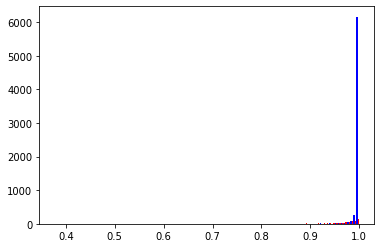

In [26]:
import matplotlib.pyplot as plt
ax = plt.subplot(111)
ax.hist([probas[probas['ok']]['proba'], probas[~probas['ok']]['proba']], bins=100, label=probas['ok'], color=[(0, 0, 1), (1, 0, 0)])
None

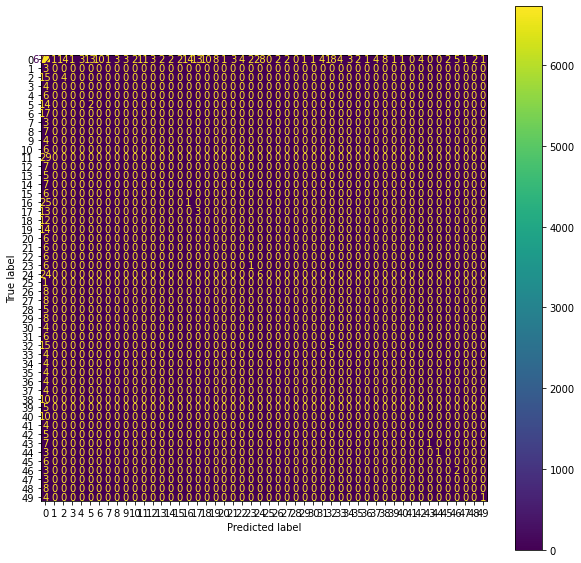

In [27]:
y_pred = probas['pred'][probas['proba'] > 0.8]
y_real = probas['real'][probas['proba'] > 0.8]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ConfusionMatrixDisplay(confusion_matrix(y_real, y_pred)).plot(ax=ax)
None

In [28]:
y_real

0        1
1        1
3        1
5        2
6        2
        ..
7549    49
7550    49
7552    49
7553    49
7555    49
Name: real, Length: 7365, dtype: int64